In [1]:
import akshare as ak
import json
import pandas as pd
import sys
import datetime
import os
import numpy as np
import pandas as pd
import pyecharts.options as opts
from pyecharts.charts import Line
from pyecharts.commons.utils import JsCode
from pyecharts import options as opts
from pyecharts.charts import Scatter
from pyecharts.options import InitOpts
from pyecharts import options as opts
from pyecharts.charts import Bar, Grid, Line
import matplotlib.pyplot as plt
from pyecharts import options as opts
from pyecharts.charts import Bar
%matplotlib inline


def convert_time(x):
    return str(x).replace(' 00:00:00','')
    
import re
sys.path.append('..')
from configure.settings import DBSelector
db = DBSelector()
mongo = db.mongo('qq')
fund = mongo['fund']

In [12]:
def get_net_value(code):
    '''
    获取基金的净值
    '''
    fund_open_fund_info_em_df = ak.fund_open_fund_info_em(fund=code, indicator="累计净值走势")
    return fund_open_fund_info_em_df

In [15]:
df=get_net_value('001220')

In [17]:
df.tail()

,净值日期,累计净值
1876,2023-02-22,1.639
1877,2023-02-23,1.633
1878,2023-02-24,1.624
1879,2023-02-27,1.615
1880,2023-02-28,1.627


In [9]:
def dump_mongo(df,code):
    js_str = df.to_json(orient='index')
    js_dict = json.loads(js_str)
    js_list = js_dict.values()

    fund.drop_collection(code)
    
    try:
        fund[code].insert_many(js_list)
    except Exception as e:
        print(e)

In [10]:
def start_crawl(code):
    df = get_net_value(code)
    df['净值日期']=df['净值日期'].astype(str)
    dump_mongo(df,code)

In [4]:
txt='''
1、$国泰大农业股票A(F001579)$ 基金经理程洲，今年以来回报-4.04%，近一年回报0.22%，近一年最大回撤-14.40%，二季度末规模12.87亿。

2、$银华农业产业股票(F005106)$ 基金经理唐能，今年以来回报-6.90%，近一年回报1.01%，近一年最大回撤-22.40%，二季度末规模12.78亿。

3、$前海开源沪港深农业混合（LOF）A(F164403)$ 基金经理吴国清,刘宏，今年以来回报2.97%，近一年回报8.20%，近一年最大回撤-21.68%，二季度末规模4.21亿

4、$嘉实农业产业股票(F003634)$ 基金经理吴越,朱子君，今年以来回报-7.38%，近一年回报3.37%，近一年最大回撤-19.06%，二季度末规模26.71亿。

5、$财通智慧成长混合A(F009062)$ 基金经理金梓才、钟俊，今年以来回报2.89%，近一年回报-21.17%，近一年最大回撤-30.49%，二季度末规模2.56亿。

6、$天弘中证农业主题指数A(F010769)$ 跟踪中证农业主题指数，今年以来回报-4.32%，近一年回报2.76%，近一年最大回撤-16.96%，二季度末规模2.24亿。

7、$国泰中证畜牧养殖ETF联接A(F012724)$ 跟踪中证畜牧养殖指数，今年以来回报-2.47%，近一年回报14.62%，近一年最大回撤-20.36%，二季度末规模2.38亿。

8、$华宝中证全指农牧渔指数发起式A(F013471)$ 跟踪中证全指农牧渔指数，今年以来回报-2.81%，成立以来回报1.33%，近一年最大回撤-17.85%，二季度末规模0.21亿。

9、$前海开源中证大农业指数增强A(F001027)$ 跟踪中证大农业指数，今年以来回报-10.06%，近一年回报-6.79%，近一年最大回撤-19.06%，二季度末规模6.82亿。（以上数据截至于2022年9月15日）

'''

In [2]:
txt='[$南方转型混合A(F001667)$](http://xueqiu.com/S/F001667) [$易方达瑞恒混合(F001832)$](http://xueqiu.com/S/F001832) [$易方达新经济混合(F001018)$](http://xueqiu.com/S/F001018) [$华安安信消费混合(F519002)$](http://xueqiu.com/S/F519002) [$万家颐和灵活配置混合(F519198)$](http://xueqiu.com/S/F519198) [$国富深化价值混合(F450004)$](http://xueqiu.com/S/F450004) [$工银战略转型股票(F000991)$](http://xueqiu.com/S/F000991) [$招商制造业混合(F001869)$](http://xueqiu.com/S/F001869) [$易方达行业领先企业(F110015)$](http://xueqiu.com/S/F110015) [$民生加银研究精选混合(F001220)$](http://xueqiu.com/S/F001220) '

In [5]:
code_txt = '''
118002	易方达标普消费品
486002	工银全球精选股票
006373	国富全球科技互联
000369	广发全球医疗保健
100055	富国全球科技互联
160416	华安标普全球石油
320013	诺安全球黄金
161815	银华抗通胀主题
'''
re_pattern = re.findall('(\d+)\s+(\w+)',code_txt)

In [7]:
code_list =[]
fund_dict ={}
for code,name in re_pattern:
    code_list.append(code)
    fund_dict[code]=name

In [3]:
code_list = re.findall('\(F(\d+)\)',txt)
fund_name = re.findall('\$(.*?)\$',txt)
fund_dict = dict(zip(code_list,fund_name))
name_list  = list(fund_dict.values())
simple_name = [i.split('(')[0] for i in name_list]

In [8]:
len(code_list)

10

In [10]:
code_list

['001667',
 '001832',
 '001018',
 '519002',
 '519198',
 '450004',
 '000991',
 '001869',
 '110015',
 '001220']

In [11]:
for code in code_list:
    start_crawl(code)

In [4]:
fund_dict

{'001667': '南方转型混合A(F001667)',
 '001832': '易方达瑞恒混合(F001832)',
 '001018': '易方达新经济混合(F001018)',
 '519002': '华安安信消费混合(F519002)',
 '519198': '万家颐和灵活配置混合(F519198)',
 '450004': '国富深化价值混合(F450004)',
 '000991': '工银战略转型股票(F000991)',
 '001869': '招商制造业混合(F001869)',
 '110015': '易方达行业领先企业(F110015)',
 '001220': '民生加银研究精选混合(F001220)'}

In [60]:
# after fetch data

In [13]:
def plot_profit_line(df,code):
    title="{}基金收益率曲线".format(code)
    X=df['净值日期'].tolist()
    Y=list(map(lambda x:round(x,2),df['累计净值'].tolist()))
    c = (
        Line()
        .add_xaxis(X)
        .add_yaxis('', Y, is_smooth=True,
            label_opts=opts.LabelOpts(is_show=False),
            linestyle_opts=opts.LineStyleOpts(width=1,color='rgb(255, 0, 0)'),
        ).set_global_opts(
            title_opts=opts.TitleOpts(title=title),
            xaxis_opts=opts.AxisOpts(
                                    name='日期',
                                    # min_interval=5,
                                    splitline_opts=opts.SplitLineOpts(is_show=True),
                                            axislabel_opts=opts.LabelOpts(rotate=45),

                                    ),
            yaxis_opts=opts.AxisOpts(
                                    min_=min(Y),
                                    max_=max(Y),
                splitline_opts=opts.SplitLineOpts(is_show=True),
            )
                                        ).set_colors(['green'])
        .render(f"../plot_image/{title}.html")
    )

In [14]:
for code,name in fund_dict.items():
    result = []
    for item in fund[code].find({},{'_id':0}):
        result.append(item)
    df = pd.DataFrame(result)
    plot_profit_line(df,name)

In [67]:
W=10000
focus_num = [
3.98*W,
7519,
72,
309,
]

In [17]:
c = (
    Scatter(InitOpts(width='800px',height='500px'))
    .add_xaxis(simple_name)
    .add_yaxis('A',focus_num,label_opts=opts.LabelOpts(is_show=True))
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(
                                    # name='日期',
                                    # min_interval=5,
                                    splitline_opts=opts.SplitLineOpts(is_show=True),
                                            axislabel_opts=opts.LabelOpts(rotate=-45),

                                    ),
        yaxis_opts=opts.AxisOpts(    
            min_=0,
                splitline_opts=opts.SplitLineOpts(is_show=True),
            ),
        title_opts=opts.TitleOpts(title="welcome"),
        visualmap_opts=opts.VisualMapOpts(type_="size",max_=150000, min_=2000),
    )
    .render("5fund.html")
)

In [69]:
grid = (
    Grid(init_opts=opts.InitOpts())
    .add(c, grid_opts=opts.GridOpts(pos_bottom="40%"))
    .render("grid_verticalfund.html")
)

In [68]:

c = (
    Bar()
    .add_xaxis(
    new_name
    )
    .add_yaxis("基金关注度", focus_num,label_opts=opts.LabelOpts(is_show=True))
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=0)),
        title_opts=opts.TitleOpts(title="基金关注度"),
    )
    # .render("基金关注度.html")
)

In [65]:
new_name = []
for name in simple_name:
    new_name.append('\n'.join(list(name)))

In [73]:
new_name

['华\n安\n纳\n斯\n达\n克\n1\n0\n0\n指\n数',
 '博\n时\n标\n普\n5\n0\n0\nE\nT\nF\n联\n接',
 '天\n弘\n恒\n生\n科\n技\n指\n数\nA',
 '嘉\n实\n港\n股\n通\n新\n经\n济\n指\n数\nA',
 '华\n夏\n恒\n生\nE\nT\nF\n联\n接',
 '易\n方\n达\n中\n概\n互\n联\n5\n0\nE\nT\nF\n联\n接\n人\n民\n币\nA',
 '交\n银\n中\n证\n海\n外\n中\n国\n互\n联\n网\n指\n数',
 '华\n安\n香\n港\n精\n选',
 '中\n欧\n丰\n泓\n沪\n港\n深\nA']

In [17]:
def get_net_value_df(code):
    '''
    从mongodb获取数据
    '''
    result=[]
    for item in fund[code].find({},{'_id':0}):
        result.append(item)
    df = pd.DataFrame(result)
    return df

In [22]:
def get_year(start,end):
    '''
    获取年份
    '''
    year = (datetime.datetime.strptime(end,'%Y-%m-%d')- datetime.datetime.strptime(start,'%Y-%m-%d')).days/365
    return year

In [21]:
def get_profit_rate(df):
    '''
    计算所有的收益率
    '''
    return round((df['累计净值'].iloc[-1]-df['累计净值'].iloc[0])/df['累计净值'].iloc[0],4)

In [20]:
def get_yearly_profit_rate(df):
    '''
    计算年化收益率
    '''
    
    start = df['净值日期'].iloc[0]
    end = df['净值日期'].iloc[-1]
    year = get_year(start,end)
    print('开始时间：',start)
    print('成立年数：',round(year,2),'年')
    profit = get_profit_rate(df)
    print('成立以来累积收益率:',profit)
    year_profit = (1+profit)**(1/year)-1
    return start,round(year,4),profit,round(year_profit,4)



In [19]:

def fund_profit(code):
    '''
    生成字典
    '''

    df = get_net_value_df(code)
    max_withdraw,max_date_index = get_max_withdraw(df['累计净值'].tolist())
    start,year,profit,year_profit = get_yearly_profit_rate(df)
    d={}
    d['代码']=code
    d['名称']=fund_dict.get(code)
    d['发行日期']=start
    d['成立年数']=year
    d['累积收益率']=profit
    d['年化收益率']=year_profit
    d['最大回撤']=max_withdraw
    return d

In [18]:
def get_max_withdraw(indexs):
    max_withdraw = 0
    start_date_index =0
    max_date_index =0
    last_high = indexs[0]
    
    for index,current in enumerate(indexs):
        # 遍历所有数据
        if current>last_high:
            last_high=current
            # start_date_index=index
            continue

        if (last_high-current)/last_high>max_withdraw:
            # 找到一个最大值时，保存其位置
            max_withdraw = (last_high-current)/last_high
            max_date_index=index

    return max_withdraw,max_date_index # 变成百分比

In [24]:
result = []
for code in code_list:
    d = fund_profit(code)
    result.append(d)

开始时间： 2016-08-17
成立年数： 6.54 年
成立以来累积收益率: 1.045
开始时间： 2018-01-10
成立年数： 5.14 年
成立以来累积收益率: 1.651
开始时间： 2015-02-12
成立年数： 8.05 年
成立以来累积收益率: 3.065
开始时间： 2013-06-24
成立年数： 9.69 年
成立以来累积收益率: 3.8348
开始时间： 2016-06-23
成立年数： 6.69 年
成立以来累积收益率: 1.2263
开始时间： 2008-07-03
成立年数： 14.67 年
成立以来累积收益率: 2.1763
开始时间： 2015-02-16
成立年数： 8.04 年
成立以来累积收益率: 2.926
开始时间： 2015-12-02
成立年数： 7.25 年
成立以来累积收益率: 1.551
开始时间： 2009-03-26
成立年数： 13.94 年
成立以来累积收益率: 3.652
开始时间： 2015-05-27
成立年数： 7.76 年
成立以来累积收益率: 0.627


In [25]:
df = pd.DataFrame(result)

In [26]:
df.head(20)

,代码,名称,发行日期,成立年数,累积收益率,年化收益率,最大回撤
0,001667,南方转型混合A(F001667),2016-08-17,6.5370,1.0450,0.1157,0.379942
1,001832,易方达瑞恒混合(F001832),2018-01-10,5.1370,1.6510,0.2090,0.318008
2,001018,易方达新经济混合(F001018),2015-02-12,8.0493,3.0650,0.1903,0.530127
3,519002,华安安信消费混合(F519002),2013-06-24,9.6877,3.8348,0.1766,0.553866
4,519198,万家颐和灵活配置混合(F519198),2016-06-23,6.6877,1.2263,0.1271,0.215814
5,450004,国富深化价值混合(F450004),2008-07-03,14.6658,2.1763,0.0820,0.563310
6,000991,工银战略转型股票(F000991),2015-02-16,8.0384,2.9260,0.1855,0.525873
7,001869,招商制造业混合(F001869),2015-12-02,7.2466,1.5510,0.1380,0.280000
8,110015,易方达行业领先企业(F110015),2009-03-26,13.9370,3.6520,0.1166,0.512736
9,001220,民生加银研究精选混合(F001220),2015-05-27,7.7644,0.6270,0.0647,0.401180


In [27]:
df['累积收益率']=df['累积收益率'].map(lambda x:x*100)
df['年化收益率']=df['年化收益率'].map(lambda x:x*100)
df['最大回撤']=df['最大回撤'].map(lambda x:x*100)


In [28]:
df.sort_values('年化收益率',ascending=False).head(10).to_excel('大盘.xlsx',encoding='utf8')

In [18]:
import pandas as pd

result = pd.DataFrame()

for code in code_list:
    df_ = get_net_value_df(code)
    df_=df_.rename(columns={'累计净值':code})
    # del df_['日增长率']
    df_['净值日期']=pd.to_datetime(df_['净值日期'],format='%Y-%m-%d')
    df_=df_.set_index('净值日期',drop=True)
    # result.append(df)
    if len(result)==0:
        result=df_

    else:
        result = pd.merge(result,df_,how='outer',left_index=True,right_index=True)

    

In [20]:
index_info = result.index.tolist()

In [22]:
index_date = list(set(index_info))


In [24]:
date_list = []
for i in index_date:
    date_list.append(i.strftime('%Y-%m-%d'))

In [26]:
new_date_list = list(sorted(date_list))

In [27]:
new_date_list[0]

'2010-05-25'

In [28]:
recent_result = result['2020-07-01':]

In [47]:
recent_result

,001667,001832,001018,519002,519198,450004,000991,001869,110015,001220
净值日期,,,,,,,,,,
2018-05-11,0.840,0.982,1.666,1.759,1.0306,1.6860,1.288,1.305,2.617,0.782
2018-05-14,0.841,1.001,1.675,1.761,1.0304,1.6910,1.281,1.305,2.644,0.787
2018-05-15,0.848,1.007,1.702,1.768,1.0302,1.7020,1.297,1.318,2.661,0.790
2018-05-16,0.848,1.008,1.686,1.759,1.0290,1.6970,1.293,1.315,2.650,0.789
2018-05-17,0.842,0.985,1.664,1.748,1.0284,1.6850,1.282,1.305,2.620,0.784
...,...,...,...,...,...,...,...,...,...,...
2023-02-22,2.059,2.672,4.061,4.932,2.2183,3.1972,3.951,2.567,4.670,1.639
2023-02-23,2.061,2.674,4.058,4.918,2.2231,3.1978,3.941,2.574,4.685,1.633
2023-02-24,2.045,2.644,4.042,4.881,2.2124,3.1776,3.912,2.553,4.632,1.624


In [45]:
recent_result1=recent_result*100

In [46]:
import numpy as np
np.round(recent_result1.corr(),2)

,001667,001832,001018,519002,519198,450004,000991,001869,110015,001220
001667,1.00,0.98,0.99,0.99,0.93,1.00,0.99,0.99,0.98,0.99
001832,0.98,1.00,0.96,0.95,0.92,0.97,0.97,0.97,0.98,0.96
001018,0.99,0.96,1.00,0.99,0.94,0.99,0.98,0.98,0.96,0.99
519002,0.99,0.95,0.99,1.00,0.94,0.98,0.99,0.97,0.95,0.98
519198,0.93,0.92,0.94,0.94,1.00,0.91,0.96,0.88,0.86,0.91
450004,1.00,0.97,0.99,0.98,0.91,1.00,0.98,0.99,0.98,0.99
000991,0.99,0.97,0.98,0.99,0.96,0.98,1.00,0.96,0.94,0.97
001869,0.99,0.97,0.98,0.97,0.88,0.99,0.96,1.00,0.99,0.99
110015,0.98,0.98,0.96,0.95,0.86,0.98,0.94,0.99,1.00,0.97
001220,0.99,0.96,0.99,0.98,0.91,0.99,0.97,0.99,0.97,1.00


In [39]:
X=np.round(recent_result.corr(),2)

In [40]:
import matplotlib.pyplot as plt

In [41]:
import seaborn as sns
%matplotlib inline

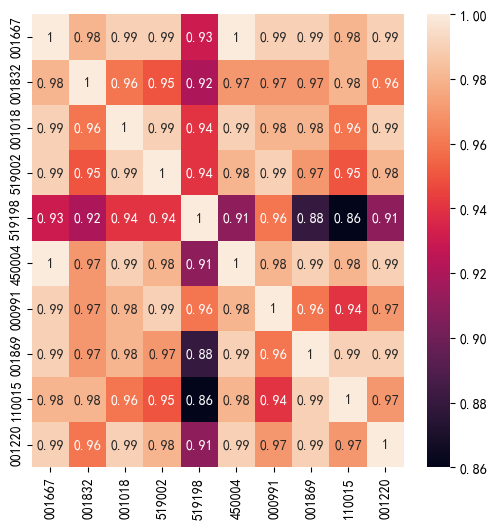

In [43]:
plt.figure(figsize=(6,6),dpi=100)
sns.heatmap(X,annot=True)
plt.show()

In [29]:
result_na = result.dropna(axis=0)

In [32]:
recent_na= result_na['2020-07-01':]

In [34]:
recent_na

,118002,486002,006373,000369,100055,160416,320013,161815
净值日期,,,,,,,,
2020-07-02,2.066,2.678,1.8035,1.846,2.1676,0.876,1.195,0.419
2020-07-06,2.115,2.726,1.8522,1.864,2.2287,0.879,1.201,0.423
2020-07-07,2.098,2.690,1.8169,1.840,2.1858,0.860,1.202,0.420
2020-07-08,2.093,2.714,1.8567,1.835,2.2511,0.856,1.210,0.423
2020-07-09,2.099,2.712,1.9092,1.821,2.3073,0.833,1.202,0.418
...,...,...,...,...,...,...,...,...
2023-06-27,3.091,3.017,2.4052,2.319,2.0626,1.527,1.242,0.674
2023-06-28,3.122,3.022,2.4019,2.317,2.0475,1.536,1.237,0.671
2023-06-29,3.143,3.028,2.4048,2.330,2.0381,1.549,1.238,0.673


In [109]:
profit_df = pd.DataFrame(result)

In [110]:
profit_df['最大回撤']=profit_df['最大回撤'].map(lambda x:round(x*100,2))
profit_df['累积收益率']=profit_df['累积收益率'].map(lambda x:round(x*100,2))
profit_df['年化收益率']=profit_df['年化收益率'].map(lambda x:round(x*100,2))


In [111]:
profit_df.head(20)

,代码,名称,发行日期,成立年数,累积收益率,年化收益率,最大回撤
0,501059,西部利得国企红利指数增强A(F501059),2018-07-11,4.18,115.0,20.0,19.28
1,005561,创金合信中证红利低波动指数A(F005561),2018-04-26,4.39,65.0,12.0,19.74
2,161907,万家中证红利指数(LOF)A(F161907),2011-03-17,11.50,136.0,8.0,46.84
3,501029,华宝红利基金(F501029),2017-01-18,5.66,40.0,6.0,28.74
4,008928,泰达消费红利指数A(F008928),2020-03-26,2.47,76.0,26.0,18.13
5,004814,中欧红利优享混合A(F004814),2018-04-19,4.41,69.0,13.0,25.26
6,005618,融通红利机会混合A(F005618),2018-03-27,4.47,98.0,17.0,15.30
7,080005,长盛量化红利混合(F080005),2009-11-25,12.81,238.0,10.0,53.00
8,008163,南方大盘红利低波50ETF联接A(F008163),2020-01-21,2.65,23.0,8.0,12.26
9,006658,财通中证香港红利等权指数A(F006658),2019-04-26,3.39,-21.0,-7.0,29.02


In [112]:
profit_df.sort_values(by='年化收益率',ascending=False).head(20)

,代码,名称,发行日期,成立年数,累积收益率,年化收益率,最大回撤
4,008928,泰达消费红利指数A(F008928),2020-03-26,2.47,76.0,26.0,18.13
0,501059,西部利得国企红利指数增强A(F501059),2018-07-11,4.18,115.0,20.0,19.28
6,005618,融通红利机会混合A(F005618),2018-03-27,4.47,98.0,17.0,15.30
5,004814,中欧红利优享混合A(F004814),2018-04-19,4.41,69.0,13.0,25.26
1,005561,创金合信中证红利低波动指数A(F005561),2018-04-26,4.39,65.0,12.0,19.74
7,080005,长盛量化红利混合(F080005),2009-11-25,12.81,238.0,10.0,53.00
2,161907,万家中证红利指数(LOF)A(F161907),2011-03-17,11.50,136.0,8.0,46.84
8,008163,南方大盘红利低波50ETF联接A(F008163),2020-01-21,2.65,23.0,8.0,12.26
3,501029,华宝红利基金(F501029),2017-01-18,5.66,40.0,6.0,28.74
10,007751,景顺长城中证沪港深红利低波A(F007751),2019-09-06,3.02,14.0,4.0,19.54


In [25]:
profit_df.to_excel('fund红利.xlsx',encoding='utf8')

In [22]:
code_list[0]

'001594'

In [81]:
def automatic_investment_plan(code):
    '''
    定投收益
    '''
    df = get_net_value_df(code)

    money = 10000
    total_share =0 
    interval = 22
    length = len(df)
    sum_money=0
    count=0
    for i in range(0,length,interval):
        buy_date_df = df.iloc[i]
        share = money/buy_date_df['单位净值']
        total_share+=share
        sum_money+=money
        count+=1
    virtual_profit = (df.iloc[-1]['单位净值']*total_share-sum_money)/sum_money
    data=[]
    year,month,day=df.iloc[0]['净值日期'].split('-')
    for i in range(count):
        data.append((datetime.date(int(year), int(month), int(day))+datetime.timedelta(days=i*30), -1*money))
    current_money = df.iloc[-1]['单位净值']*total_share
    data.append((datetime.date(int(year), int(month), int(day))+datetime.timedelta(days=i*30),current_money))
    percent = xirr(data)
    every_round_profit = irr([money]*count+[-1*current_money])
    real_profit = pow(every_round_profit+1,count)-1
    return code,sum_money,round(current_money,2),round(percent,4),round(virtual_profit,4),round(real_profit,4)

In [82]:
def xirr(cashflows):
    # 函数
    years = [(ta[0] - cashflows[0][0]).days / 365. for ta in cashflows]
    residual = 1.0
    step = 0.05
    guess = 0.05
    epsilon = 0.0001
    limit = 10000
    while abs(residual) > epsilon and limit > 0:
        limit -= 1
        residual = 0.0
        for i, trans in enumerate(cashflows):
            residual += trans[1] / pow(guess, years[i])
        if abs(residual) > epsilon:
            if residual > 0:
                guess += step
            else:
                guess -= step
                step /= 2.0
    return guess - 1


In [ ]:
# 测试
data = [(datetime.date(2006, 1, 24), -39967), (datetime.date(2008, 2, 6), -19866), (datetime.date(2010, 10, 18), 245706), (datetime.date(2013, 9, 14), 52142)]
xirr(data)

In [56]:
result =[]
for code in code_list:
    d={}
    code,sum_money,current_money,percent,virtual_profit,real_profit=automatic_investment_plan(code)
    d['代码']=code
    d['投入总金额']=sum_money
    d['目前总金额']=current_money
    d['总收益']=percent
    d['简单收益率']=virtual_profit
    d['irr收益率']=real_profit
    result.append(d)
df = pd.DataFrame(result)


740000 891983.51
001594 0.06 0.21 0.43
740000 838011.42
502010 0.04 0.13 0.27
730000 548702.23
167301 -0.1 -0.25 -0.45
60000 62541.56
013273 0.22 0.04 0.07
140000 138765.67
010696 -0.02 -0.01 -0.02


In [53]:
df.head()

,代码,投入总金额,目前总金额,总收益,简单收益率,irr收益率
0,001594,740000,891983.51,0.06,20.54,0.43
1,502010,740000,838011.42,0.04,13.24,0.27
2,167301,730000,548702.23,-0.10,-24.84,-0.45
3,013273,60000,62541.56,0.22,4.24,0.07
4,010696,140000,138765.67,-0.02,-0.88,-0.02


In [57]:
df.to_excel('定投.xlsx',encoding='utf8')

In [83]:
def irr(values):
    """
    Return the Internal Rate of Return (IRR).
    .. deprecated:: 1.18
       `irr` is deprecated; for details, see NEP 32 [1]_.
       Use the corresponding function in the numpy-financial library,
       https://pypi.org/project/numpy-financial.
    This is the "average" periodically compounded rate of return
    that gives a net present value of 0.0; for a more complete explanation,
    see Notes below.
    :class:`decimal.Decimal` type is not supported.
    Parameters
    ----------
    values : array_like, shape(N,)
        Input cash flows per time period.  By convention, net "deposits"
        are negative and net "withdrawals" are positive.  Thus, for
        example, at least the first element of `values`, which represents
        the initial investment, will typically be negative.
    Returns
    -------
    out : float
        Internal Rate of Return for periodic input values.
    Notes
    -----
    The IRR is perhaps best understood through an example (illustrated
    using np.irr in the Examples section below).  Suppose one invests 100
    units and then makes the following withdrawals at regular (fixed)
    intervals: 39, 59, 55, 20.  Assuming the ending value is 0, one's 100
    unit investment yields 173 units; however, due to the combination of
    compounding and the periodic withdrawals, the "average" rate of return
    is neither simply 0.73/4 nor (1.73)^0.25-1.  Rather, it is the solution
    (for :math:`r`) of the equation:
    .. math:: -100 + \\frac{39}{1+r} + \\frac{59}{(1+r)^2}
     + \\frac{55}{(1+r)^3} + \\frac{20}{(1+r)^4} = 0
    In general, for `values` :math:`= [v_0, v_1, ... v_M]`,
    irr is the solution of the equation: [2]_
    .. math:: \\sum_{t=0}^M{\\frac{v_t}{(1+irr)^{t}}} = 0
    References
    ----------
    .. [1] NumPy Enhancement Proposal (NEP) 32,
       https://numpy.org/neps/nep-0032-remove-financial-functions.html
    .. [2] L. J. Gitman, "Principles of Managerial Finance, Brief," 3rd ed.,
       Addison-Wesley, 2003, pg. 348.
    Examples
    --------
    >>> round(np.irr([-100, 39, 59, 55, 20]), 5)
    0.28095
    >>> round(np.irr([-100, 0, 0, 74]), 5)
    -0.0955
    >>> round(np.irr([-100, 100, 0, -7]), 5)
    -0.0833
    >>> round(np.irr([-100, 100, 0, 7]), 5)
    0.06206
    >>> round(np.irr([-5, 10.5, 1, -8, 1]), 5)
    0.0886
    """
    # `np.roots` call is why this function does not support Decimal type.
    #
    # Ultimately Decimal support needs to be added to np.roots, which has
    # greater implications on the entire linear algebra module and how it does
    # eigenvalue computations.
    res = np.roots(values[::-1])  # 求根，对于n次多项式，p[0] * x**n + p[1] * x**(n-1) + ... + p[n-1]*x + p[n]，传入p的列表参数[p[0],p[1],...p[n]].
    mask = (res.imag == 0) & (res.real > 0)  # 虚部为0，实部为非负数。
    if not mask.any():  # 判断是否有满足条件的实根
        return np.nan  # 不满足，返回Not A Number
    res = res[mask].real
    # NPV(rate) = 0 can have more than one solution so we return
    # only the solution closest to zero.
    rate = 1/res - 1  # 这里解出的res，也就是符合条件的x，其实等于1/(1+r)，因此要做一个变换回去，r=1/x-1
    rate = rate.item(np.argmin(np.abs(rate)))  # argmin()取最小值的下标，也就是说可能会计算出多个折现率，我们取最小那个
    return rate

In [1]:
import requests

headers = {
    'authority': 'api.jiucaishuo.com',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="98", "Google Chrome";v="98"',
    'accept': 'application/json, text/plain, */*',
    'content-type': 'application/json;charset=UTF-8',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36',
    'sec-ch-ua-platform': '"Linux"',
    'origin': 'https://www.funddb.cn',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'accept-language': 'zh,en;q=0.9,en-US;q=0.8,zh-CN;q=0.7',
}

data = '{"code":"013273","category":"wind_category","date":"","type":"pc","data_source":"xichou","version":"1.8.9","authtoken":"","act_time":1645634683356,"tirgkjfs":"fb","abiokytke":"52","u54rg5d":"76","kf54ge7":"f","tiklsktr4":"b","lksytkjh":"0ba1","sbnoywr":"27","bgd7h8tyu54":"46","y654b5fs3tr":"d","bioduytlw":"6","bd4uy742":"4","h67456y":"70b","bvytikwqjk":"46","ngd4uy551":"0b","bgiuytkw":"bc","nd354uy4752":"4","ghtoiutkmlg":"db8","bd24y6421f":"7e","tbvdiuytk":"7","ibvytiqjek":"1d","jnhf8u5231":"bc","fjlkatj":"760","hy5641d321t":"e4","iogojti":"e","ngd4yut78":"b8","nkjhrew":"4","yt447e13f":"1","n3bf4uj7y7":"b","nbf4uj7y432":"52","yi854tew":"54","h13ey474":"54f","quikgdky":"c3"}'

response = requests.post('https://api.jiucaishuo.com/v2/fund-lists/fundinvest', headers=headers, data=data)

In [4]:
result = response.json()

In [ ]:
result['data']['gp']['list']

In [15]:
def read_data_from_mongo(code):
    result=[]
    for item in fund[code].find():
        result.append(item)

    df = pd.DataFrame(result)
    return df

In [7]:
df = read_data_from_mongo(code_list[0])

In [8]:
df.head()

,_id,净值日期,单位净值,日增长率
0,621659cc28d482b10a0e5c05,2015-07-08,1.0000,0.0000
1,621659cc28d482b10a0e5c06,2015-07-10,1.0815,0.0000
2,621659cc28d482b10a0e5c07,2015-07-13,1.0514,-2.7832
3,621659cc28d482b10a0e5c08,2015-07-14,1.0324,-1.8071
4,621659cc28d482b10a0e5c09,2015-07-15,1.0498,1.6854


In [ ]:
c = (
    Scatter(InitOpts(width='800px',height='500px'))
    .add_xaxis(simple_name)
    .add_yaxis('A',focus_num,label_opts=opts.LabelOpts(is_show=True))
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(
                                    # name='日期',
                                    # min_interval=5,
                                    splitline_opts=opts.SplitLineOpts(is_show=True),
                                            axislabel_opts=opts.LabelOpts(rotate=-45),

                                    ),
        yaxis_opts=opts.AxisOpts(    
            min_=0,
                splitline_opts=opts.SplitLineOpts(is_show=True),
            ),
        title_opts=opts.TitleOpts(title="红利基金收益率曲线"),
        visualmap_opts=opts.VisualMapOpts(type_="size",max_=150000, min_=2000),
    )
    .render("../plot_image/红利.html")
)

In [ ]:
c = (
    Line()
    .add_xaxis(X)
    .add_yaxis(title, Y, is_smooth=True,
    label_opts=opts.LabelOpts(is_show=False),
linestyle_opts=opts.LineStyleOpts(width=2,color='rgb(255, 0, 0)'),
    ).add_yaxis(title2, Y2, is_smooth=True,
linestyle_opts=opts.LineStyleOpts(width=2,color='rgb(0, 0, 255)'),
label_opts=opts.LabelOpts(is_show=False),
    ).add_yaxis(title3, Y3, is_smooth=True,
linestyle_opts=opts.LineStyleOpts(width=2,color='rgb(0, 255, 0)'),
label_opts=opts.LabelOpts(is_show=False),
    ).set_global_opts(
        title_opts=opts.TitleOpts(title=full_title),
        xaxis_opts=opts.AxisOpts(
                                name='日期',
                                min_interval=1,
                                splitline_opts=opts.SplitLineOpts(is_show=True),
           axislabel_opts=opts.LabelOpts(rotate=55),
                                ),
        yaxis_opts=opts.AxisOpts(name='收益率%',
                                interval=3,
                                 min_=y_min-2,
                                 max_=y_max+2,
            splitline_opts=opts.SplitLineOpts(is_show=True),
        )
                                    )
                                    .set_colors(['red','blue','green']) # 点的颜色
    .render(f"../plot_image/多曲线plot_line_{name}_{types}_{date}_{rotation_rate}.html")
)

In [118]:
c=Line()

In [119]:
X=result_na.index.tolist()
X=list(map(lambda x:x.strftime('%Y-%m-%d'),X))
c=c.add_xaxis(X)

In [120]:

for code,name in fund_dict.items():
    Y=result_na[code].tolist()
    c=c.add_yaxis(name, Y, is_smooth=True,
    label_opts=opts.LabelOpts(is_show=False),
linestyle_opts=opts.LineStyleOpts(width=1,color='rgb(255, 0, 0)'),
    )

In [31]:
c.set_global_opts(
        title_opts=opts.TitleOpts(title='ddddd'),
        xaxis_opts=opts.AxisOpts(
                                name='日期',
                                # min_interval=1,
                                splitline_opts=opts.SplitLineOpts(is_show=True),
           axislabel_opts=opts.LabelOpts(rotate=55),
                                ),
        yaxis_opts=opts.AxisOpts(name='收益率%',
                                # interval=3,
                                 min_=0.6,
                                 max_=2.8,
            splitline_opts=opts.SplitLineOpts(is_show=True),
        )
                                    ).set_colors(['red','blue','green']) # 点的颜色


In [32]:
c.render(f"../plot_image/多曲线plot_line_1111223.html")


'/home/xda/github/stock/plot_image/多曲线plot_line_1111223.html'

In [14]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [30]:
result_na.head()


,118002,486002,006373,000369,100055,160416,320013,161815
净值日期,,,,,,,,
2018-11-20,1.702,2.058,1.0000,1.601,1.3684,1.052,0.867,0.468
2018-11-23,1.717,2.063,1.0001,1.599,1.3795,1.035,0.867,0.458
2018-11-30,1.726,2.158,1.0003,1.658,1.3908,1.059,0.866,0.454
2018-12-07,1.668,2.053,1.0002,1.575,1.3383,1.031,0.874,0.456
2018-12-14,1.675,2.043,1.0003,1.553,1.3255,1.008,0.869,0.454


In [35]:
# new_df = result_na.copy()
new_df=recent_na

In [36]:
base=new_df.iloc[0]

In [37]:
base

118002    2.0660
486002    2.6780
006373    1.8035
000369    1.8460
100055    2.1676
160416    0.8760
320013    1.1950
161815    0.4190
Name: 2020-07-02 00:00:00, dtype: float64

In [128]:
base['501059']

1.1887

In [38]:
def convert(x,code):
    b=base[code]
    return x/b

In [39]:
for code,name in fund_dict.items():
    new_df['{}'.format(code)]=new_df[code].apply(convert,args=(code,))


/tmp/ipykernel_51200/2552348715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['{}'.format(code)]=new_df[code].apply(convert,args=(code,))


In [141]:
new_df.head()

,501059,005561,161907,501029,008928,004814,005618,080005,008163,006658,007751
净值日期,,,,,,,,,,,
2020-03-26,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-03-27,1.007824,1.005951,1.006891,1.006941,1.0000,0.998462,1.001499,1.004869,1.006963,1.013702,1.006048
2020-04-03,1.003113,0.997662,0.995621,0.998107,1.0009,0.987591,1.010095,0.998229,0.997152,1.013237,1.003360
2020-04-10,1.015984,1.007545,1.004959,1.007572,1.0020,1.018049,1.036044,1.003984,1.001055,1.047840,1.025874
2020-04-17,1.030369,1.015303,1.009338,1.009254,0.9952,1.024613,1.065620,1.007525,1.007596,1.053530,1.029794


In [40]:
result_na1=new_df.rename(columns=fund_dict)

In [43]:
result_na1.to_pickle('obj_test.pkl')

In [2]:
result_na1 = pd.read_pickle('obj_test.pkl')

In [6]:
result_na1.head()

,易方达标普消费品,工银全球精选股票,国富全球科技互联,广发全球医疗保健,富国全球科技互联,华安标普全球石油,诺安全球黄金,银华抗通胀主题
净值日期,,,,,,,,
2020-07-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-07-06,1.023717,1.017924,1.027003,1.009751,1.028188,1.003425,1.005021,1.009547
2020-07-07,1.015489,1.004481,1.007430,0.996750,1.008396,0.981735,1.005858,1.002387
2020-07-08,1.013069,1.013443,1.029498,0.994041,1.038522,0.977169,1.012552,1.009547
2020-07-09,1.015973,1.012696,1.058608,0.986457,1.064449,0.950913,1.005858,0.997613


In [ ]:
result_na1.to_csv('test.csv')

In [5]:
import joblib
joblib.dump(result_na1,'df-obj')


['df-obj']

In [3]:
plt.rcParams['figure.figsize'] = (16.0, 10)

<AxesSubplot:xlabel='净值日期'>

/home/xda/miniconda3/envs/cpy/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xda/miniconda3/envs/cpy/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xda/miniconda3/envs/cpy/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xda/miniconda3/envs/cpy/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xda/miniconda3/envs/cpy/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26131 (\N{CJK UNIFIED I

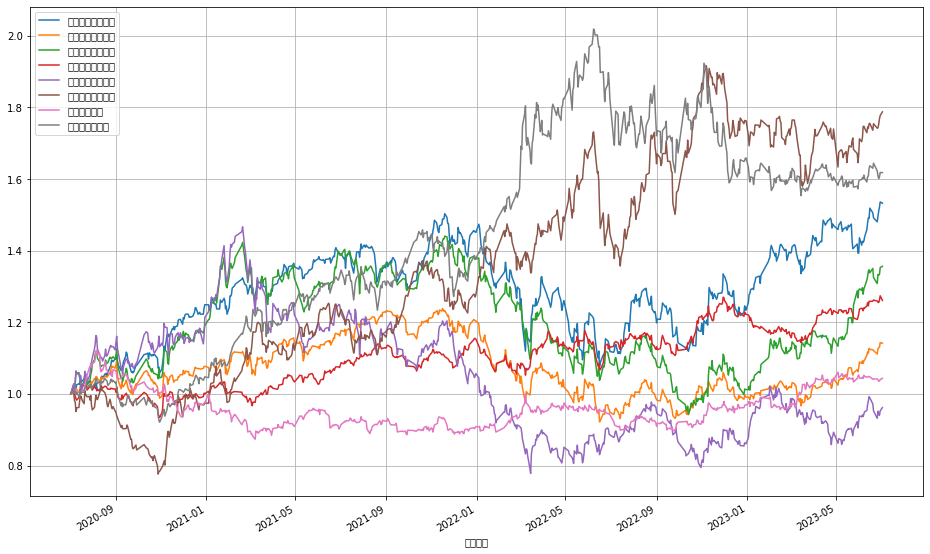

In [4]:
# plt.figure(figsize=(8,8))

result_na1.plot(grid=True,)
# plt.show()


In [14]:
for code,name in fund_dict.items():
    result = []
    for item in fund[code].find({},{'_id':0}):
        result.append(item)
    df = pd.DataFrame(result)
    plot_profit_line(df,name)

In [3]:
fund_dict

NameError: name 'fund_dict' is not defined

In [55]:
fund_portfolio_hold_em_df = ak.fund_portfolio_hold_em(code="000001", year="2023")

KeyError: '占净值比例'

In [5]:
import akshare as ak
def get_holding_list(code,year):
    fund_portfolio_hold_em_df = ak.fund_portfolio_hold_em(symbol=code, date=year)
    return fund_portfolio_hold_em_df[fund_portfolio_hold_em_df['季度']=='2022年4季度股票投资明细']

In [20]:

code='501059'
holding_dict[code] = get_holding_list(code,2022)

In [23]:
stock_list = holding_dict[code]['股票名称'].tolist()

In [6]:
holding_dict={}
for code,name in fund_dict.items():
    holding_dict[code] = get_holding_list(code,2022)

In [31]:
holding_dict['001579']

,序号,股票代码,股票名称,占净值比例,持股数,持仓市值,季度
0,1,600438,通威股份,6.50,140.00,8380.40,2022年2季度股票投资明细
1,2,300498,温氏股份,6.29,380.85,8108.40,2022年2季度股票投资明细
2,3,000902,新洋丰,5.44,415.00,7009.35,2022年2季度股票投资明细
3,4,002714,牧原股份,5.43,126.55,6994.32,2022年2季度股票投资明细
4,5,002250,联化科技,5.08,400.00,6548.00,2022年2季度股票投资明细
...,...,...,...,...,...,...,...
123,124,001268,联合精密,0.00,0.04,1.13,2022年2季度股票投资明细
124,125,301111,粤万年青,0.00,0.04,1.04,2022年2季度股票投资明细
125,126,301138,华研精机,0.00,0.03,0.88,2022年2季度股票投资明细
126,127,301158,德石股份,0.00,0.04,0.77,2022年2季度股票投资明细


In [7]:
stock_lists = []
for code,holding in holding_dict.items():
    stock_list = holding['股票名称'].tolist()
    stock_lists.extend(stock_list)

In [32]:
for code,holding in holding_dict.items():
    x=holding['股票名称'].tolist()
    
    if '贵州茅台' not in x:
        print(code)


519198
000991
001869
001220


In [31]:
holding_dict

{'001667':    序号    股票代码  股票名称  占净值比例     持股数      持仓市值              季度
 0   1  600519  贵州茅台   2.73    7.51  12964.59  2022年4季度股票投资明细
 1   2  601166  兴业银行   2.52  680.01  11961.32  2022年4季度股票投资明细
 2   3  002531  天顺风能   2.20  690.00  10439.70  2022年4季度股票投资明细
 3   4  688599  天合光能   2.15  160.00  10201.60  2022年4季度股票投资明细
 4   5  000001  平安银行   2.11  760.00  10001.61  2022年4季度股票投资明细
 5   6  600176  中国巨石   2.02  700.00   9597.01  2022年4季度股票投资明细
 6   7  600660  福耀玻璃   2.00  270.01   9469.18  2022年4季度股票投资明细
 7   8  601877  正泰电器   1.93  330.00   9141.00  2022年4季度股票投资明细
 8   9  600346  恒力石化   1.83  560.01   8696.90  2022年4季度股票投资明细
 9  10  600887  伊利股份   1.83  280.00   8680.00  2022年4季度股票投资明细,
 '001832':    序号    股票代码  股票名称  占净值比例      持股数      持仓市值              季度
 0   1  000596  古井贡酒   9.42   131.99  35229.17  2022年4季度股票投资明细
 1   2  000933  神火股份   7.90  1975.90  29559.46  2022年4季度股票投资明细
 2   3  600519  贵州茅台   7.84    16.99  29344.49  2022年4季度股票投资明细
 3   4  601899  紫金矿业   7.23  2705.50  27055.0

In [8]:
count_dict ={}
for i in stock_lists:
    count_dict.setdefault(i,0)
    count_dict[i]+=1

In [9]:
holding_ordered = sorted(count_dict.items(),key=lambda x:x[1],reverse=True)

In [28]:
len(stock_lists)

724

In [10]:
for  i in holding_ordered:
    if i[1]>=2:
        print(i[0],i[1])

贵州茅台 6
五粮液 3
兴业银行 2
伊利股份 2
紫光国微 2
立讯精密 2


In [11]:
import akshare as ak
stock_board_industry_name_em_df = ak.stock_board_industry_name_em()
print(stock_board_industry_name_em_df)

    排名   板块名称    板块代码       最新价     涨跌额   涨跌幅            总市值   换手率  上涨家数  \
0    1   通信服务  BK0736    925.33   37.86  4.27  2808561568000  4.29    41   
1    2  互联网服务  BK0447  19736.87  756.98  3.99  1616366112000  5.21   131   
2    3   软件开发  BK0737    849.00   29.68  3.62  2121979408000  5.25   164   
3    4     游戏  BK1046   1047.38   33.53  3.31   340843664000  5.21    30   
4    5  计算机设备  BK0735    984.85   27.21  2.84   920453120000  4.70    38   
..  ..    ...     ...       ...     ...   ...            ...   ...   ...   
81  82   医药商业  BK1042   1170.64   -4.06 -0.35   422802976000  1.19    10   
82  83   医疗器械  BK1041    986.08   -3.78 -0.38  1846142608000  1.21    48   
83  84   生物制品  BK1044    943.65   -4.47 -0.47  1327821648000  0.99    17   
84  85   风电设备  BK1032   1372.86   -7.07 -0.51   397853920000  0.96     6   
85  86   光伏设备  BK1031   2035.92  -33.97 -1.64  2203307024000  1.40    14   

    下跌家数  领涨股票  领涨股票-涨跌幅  
0      0  中通国脉     10.02  
1     11  金桥信息     10.00  
2     

In [12]:
bk_name = stock_board_industry_name_em_df['板块名称'].tolist()

In [13]:
bk_name[0]

'通信服务'

In [14]:
import akshare as ak
bk_result ={}
for bk in bk_name:
    stock_board_industry_cons_em_df = ak.stock_board_industry_cons_em(symbol=bk)
    st_name =stock_board_industry_cons_em_df['名称'].tolist()
    # st=['']
    bk_result[bk]=st_name

In [15]:
stock_board_industry_cons_em_df

,序号,代码,名称,最新价,涨跌幅,涨跌额,成交量,成交额,振幅,最高,最低,今开,昨收,换手率,市盈率-动态,市净率
0,1,603105,芯能科技,17.72,1.43,0.25,138796,2.432346e+08,2.58,17.75,17.30,17.50,17.47,2.78,41.32,5.11
1,2,300393,中来股份,17.18,1.12,0.19,270884,4.590574e+08,2.83,17.20,16.72,16.99,16.99,2.84,40.92,4.93
2,3,002129,TCL中环,44.12,1.08,0.47,258274,1.135493e+09,1.95,44.38,43.53,43.86,43.65,0.80,21.38,3.94
3,4,835985,海泰新能,8.94,1.02,0.09,12233,1.082701e+07,2.71,8.95,8.71,8.89,8.85,0.91,29.37,2.19
4,5,301046,能辉科技,40.70,0.74,0.30,29262,1.179232e+08,2.20,40.80,39.91,40.46,40.40,4.96,311.92,8.05
5,6,300029,ST天龙,8.29,0.48,0.04,19548,1.617148e+07,1.70,8.33,8.19,8.25,8.25,0.97,35.22,32.47
6,7,300317,珈伟新能,6.25,0.48,0.03,228560,1.415638e+08,1.93,6.25,6.13,6.20,6.22,2.95,41.43,2.82
7,8,600207,安彩高科,6.72,0.45,0.03,64537,4.306403e+07,1.64,6.73,6.62,6.70,6.69,0.75,53.12,2.32
8,9,002610,爱康科技,2.85,0.35,0.01,431486,1.225051e+08,1.41,2.86,2.82,2.85,2.84,0.98,-35.17,3.84
9,10,603628,清源股份,16.75,0.30,0.05,20764,3.453946e+07,1.26,16.75,16.54,16.67,16.70,0.76,50.36,4.29


In [16]:
belongs={}
for i in holding_ordered:
    for k,v in bk_result.items():
        if i[0] in v:
            belongs[i[0]]=k
            break


In [17]:
belongs

{'贵州茅台': '酿酒行业',
 '兴业银行': '银行',
 '伊利股份': '食品饮料',
 '紫光国微': '半导体',
 '立讯精密': '消费电子',
 '天顺风能': '风电设备',
 '天合光能': '光伏设备',
 '平安银行': '银行',
 '中国巨石': '玻璃玻纤',
 '福耀玻璃': '玻璃玻纤',
 '正泰电器': '电网设备',
 '恒力石化': '化纤行业',
 '古井贡酒': '酿酒行业',
 '神火股份': '有色金属',
 '紫金矿业': '贵金属',
 '兖矿能源': '煤炭行业',
 '潞安环能': '煤炭行业',
 '山煤国际': '煤炭行业',
 '中船防务': '船舶制造',
 '山西焦煤': '煤炭行业',
 '纳思达': '计算机设备',
 '南都电源': '电池',
 '比亚迪': '汽车整车',
 '宝信软件': '互联网服务',
 '航天宏图': '互联网服务',
 '永兴材料': '钢铁行业',
 '宁德时代': '电池',
 '华电国际': '电力行业',
 '锦江酒店': '旅游酒店',
 '京沪高铁': '物流行业',
 '老白干酒': '酿酒行业',
 '南方航空': '航空机场',
 '海尔智家': '家电行业',
 '红日药业': '中药',
 '海油工程': '采掘行业',
 '中国人寿': '保险',
 '陕西煤业': '煤炭行业',
 '上海电力': '电力行业',
 '中国神华': '煤炭行业',
 '中煤能源': '煤炭行业',
 '广发证券': '证券',
 '招商证券': '证券',
 '中信证券': '证券',
 '晋控煤业': '煤炭行业',
 '淮北矿业': '煤炭行业',
 '三峡能源': '电力行业',
 '广汇能源': '石油行业',
 '阳光电源': '光伏设备',
 '宁波银行': '银行',
 '三花智控': '家电行业',
 '卫星化学': '化学原料',
 '恒立液压': '工程机械',
 '邮储银行': '银行',
 '万华化学': '化学制品',
 '中国建筑': '工程建设',
 '保利发展': '房地产开发',
 '南京银行': '银行',
 '招商蛇口': '房地产开发',
 '光大银行': '银行',
 '金地集团': '房地产开发',
 '成都

In [26]:
result_={}
result__={}
for k,v in belongs.items():
    result_.setdefault(v,0)
    result_[v]+=1
    if v not in result__:
        result__[v]=[]
    result__[v].append(k)

In [28]:
for name,item in result__.items():
    if len(item)>3:
        print(name,item)

酿酒行业 ['贵州茅台', '古井贡酒', '老白干酒', '山西汾酒', '泸州老窖']
银行 ['兴业银行', '平安银行', '宁波银行', '邮储银行', '南京银行', '光大银行', '成都银行', '杭州银行', '江苏银行']
食品饮料 ['伊利股份', '安琪酵母', '海天味业', '安井食品']
光伏设备 ['天合光能', '阳光电源', '通威股份', '隆基绿能', '福斯特']
煤炭行业 ['兖矿能源', '潞安环能', '山煤国际', '山西焦煤', '陕西煤业', '中国神华', '中煤能源', '晋控煤业', '淮北矿业']
美容护理 ['华熙生物', '贝泰妮', '爱美客', '珀莱雅']


In [21]:

industry_dict={}
for code,df in holding_dict.items():
    h_list = df['股票名称'].tolist()
    for i in h_list:
        industry = belongs.get(i)
        industry_dict.setdefault(industry,0)
        industry_dict[industry]+=1

In [22]:
industry_dict

{'酿酒行业': 10,
 '银行': 10,
 '风电设备': 1,
 '光伏设备': 5,
 '玻璃玻纤': 2,
 '电网设备': 1,
 '化纤行业': 1,
 '食品饮料': 5,
 '有色金属': 1,
 '贵金属': 1,
 '煤炭行业': 9,
 None: 3,
 '船舶制造': 1,
 '计算机设备': 1,
 '电池': 3,
 '汽车整车': 1,
 '互联网服务': 3,
 '半导体': 2,
 '钢铁行业': 1,
 '电力行业': 3,
 '旅游酒店': 2,
 '物流行业': 2,
 '航空机场': 1,
 '家电行业': 2,
 '中药': 1,
 '采掘行业': 1,
 '保险': 1,
 '证券': 3,
 '石油行业': 1,
 '化学原料': 2,
 '工程机械': 1,
 '消费电子': 2,
 '化学制品': 2,
 '工程建设': 1,
 '房地产开发': 3,
 '生物制品': 1,
 '化学制药': 1,
 '医疗器械': 1,
 '电子元件': 1,
 '通信设备': 1,
 '美容护理': 4,
 '医疗服务': 2}

In [25]:
ret = list(sorted(industry_dict.items(),key=lambda x:x[1],reverse=True))
for name,count in ret:
    print(name,count)

酿酒行业 10
银行 10
煤炭行业 9
光伏设备 5
食品饮料 5
美容护理 4
None 3
电池 3
互联网服务 3
电力行业 3
证券 3
房地产开发 3
玻璃玻纤 2
半导体 2
旅游酒店 2
物流行业 2
家电行业 2
化学原料 2
消费电子 2
化学制品 2
医疗服务 2
风电设备 1
电网设备 1
化纤行业 1
有色金属 1
贵金属 1
船舶制造 1
计算机设备 1
汽车整车 1
钢铁行业 1
航空机场 1
中药 1
采掘行业 1
保险 1
石油行业 1
工程机械 1
工程建设 1
生物制品 1
化学制药 1
医疗器械 1
电子元件 1
通信设备 1


{'酿酒行业': ['贵州茅台', '古井贡酒', '老白干酒', '山西汾酒', '泸州老窖'],
 '银行': ['兴业银行',
  '平安银行',
  '宁波银行',
  '邮储银行',
  '南京银行',
  '光大银行',
  '成都银行',
  '杭州银行',
  '江苏银行'],
 '食品饮料': ['伊利股份', '安琪酵母', '海天味业', '安井食品'],
 '半导体': ['紫光国微'],
 '消费电子': ['立讯精密'],
 '风电设备': ['天顺风能'],
 '光伏设备': ['天合光能', '阳光电源', '通威股份', '隆基绿能', '福斯特'],
 '玻璃玻纤': ['中国巨石', '福耀玻璃'],
 '电网设备': ['正泰电器'],
 '化纤行业': ['恒力石化'],
 '有色金属': ['神火股份'],
 '贵金属': ['紫金矿业'],
 '煤炭行业': ['兖矿能源',
  '潞安环能',
  '山煤国际',
  '山西焦煤',
  '陕西煤业',
  '中国神华',
  '中煤能源',
  '晋控煤业',
  '淮北矿业'],
 '船舶制造': ['中船防务'],
 '计算机设备': ['纳思达'],
 '电池': ['南都电源', '宁德时代', '先导智能'],
 '汽车整车': ['比亚迪'],
 '互联网服务': ['宝信软件', '航天宏图', '中科创达'],
 '钢铁行业': ['永兴材料'],
 '电力行业': ['华电国际', '上海电力', '三峡能源'],
 '旅游酒店': ['锦江酒店', '中国中免'],
 '物流行业': ['京沪高铁', '圆通速递'],
 '航空机场': ['南方航空'],
 '家电行业': ['海尔智家', '三花智控'],
 '中药': ['红日药业'],
 '采掘行业': ['海油工程'],
 '保险': ['中国人寿'],
 '证券': ['广发证券', '招商证券', '中信证券'],
 '石油行业': ['广汇能源'],
 '化学原料': ['卫星化学', '华鲁恒升'],
 '工程机械': ['恒立液压'],
 '化学制品': ['万华化学', '华恒生物'],
 '工程建设': ['中国建筑'],
 '房地产开发': ['保利发展', '招商蛇口',

In [21]:
result_

{'酿酒行业': 5,
 '银行': 9,
 '食品饮料': 4,
 '半导体': 1,
 '消费电子': 1,
 '风电设备': 1,
 '光伏设备': 5,
 '玻璃玻纤': 2,
 '电网设备': 1,
 '化纤行业': 1,
 '有色金属': 1,
 '贵金属': 1,
 '煤炭行业': 9,
 '船舶制造': 1,
 '计算机设备': 1,
 '电池': 3,
 '汽车整车': 1,
 '互联网服务': 3,
 '钢铁行业': 1,
 '电力行业': 3,
 '旅游酒店': 2,
 '物流行业': 2,
 '航空机场': 1,
 '家电行业': 2,
 '中药': 1,
 '采掘行业': 1,
 '保险': 1,
 '证券': 3,
 '石油行业': 1,
 '化学原料': 2,
 '工程机械': 1,
 '化学制品': 2,
 '工程建设': 1,
 '房地产开发': 3,
 '生物制品': 1,
 '化学制药': 1,
 '医疗器械': 1,
 '电子元件': 1,
 '通信设备': 1,
 '美容护理': 4,
 '医疗服务': 2}

In [22]:
result_industry = sorted(result_.items(),key=lambda x:x[1],reverse=True)

In [37]:
for i in result_industry:
    print(i[0],i[1])
    print(result__[i[0]])

银行 9
['兴业银行', '平安银行', '宁波银行', '邮储银行', '南京银行', '光大银行', '成都银行', '杭州银行', '江苏银行']
煤炭行业 9
['兖矿能源', '潞安环能', '山煤国际', '山西焦煤', '陕西煤业', '中国神华', '中煤能源', '晋控煤业', '淮北矿业']
酿酒行业 5
['贵州茅台', '古井贡酒', '老白干酒', '山西汾酒', '泸州老窖']
光伏设备 5
['天合光能', '阳光电源', '通威股份', '隆基绿能', '福斯特']
食品饮料 4
['伊利股份', '安琪酵母', '海天味业', '安井食品']
美容护理 4
['华熙生物', '贝泰妮', '爱美客', '珀莱雅']
电池 3
['南都电源', '宁德时代', '先导智能']
互联网服务 3
['宝信软件', '航天宏图', '中科创达']
电力行业 3
['华电国际', '上海电力', '三峡能源']
证券 3
['广发证券', '招商证券', '中信证券']
房地产开发 3
['保利发展', '招商蛇口', '金地集团']
玻璃玻纤 2
['中国巨石', '福耀玻璃']
旅游酒店 2
['锦江酒店', '中国中免']
物流行业 2
['京沪高铁', '圆通速递']
家电行业 2
['海尔智家', '三花智控']
化学原料 2
['卫星化学', '华鲁恒升']
化学制品 2
['万华化学', '华恒生物']
医疗服务 2
['爱尔眼科', '通策医疗']
半导体 1
['紫光国微']
消费电子 1
['立讯精密']
风电设备 1
['天顺风能']
电网设备 1
['正泰电器']
化纤行业 1
['恒力石化']
有色金属 1
['神火股份']
贵金属 1
['紫金矿业']
船舶制造 1
['中船防务']
计算机设备 1
['纳思达']
汽车整车 1
['比亚迪']
钢铁行业 1
['永兴材料']
航空机场 1
['南方航空']
中药 1
['红日药业']
采掘行业 1
['海油工程']
保险 1
['中国人寿']
石油行业 1
['广汇能源']
工程机械 1
['恒立液压']
工程建设 1
['中国建筑']
生物制品 1
['智飞生物']
化学制药 1
['华东医药']
医疗器械 1
['鱼跃医疗']
电子元件 1
['振华科技']

In [54]:
len(holding_dict)

11

In [55]:
type(holding_dict)

dict

In [26]:
holding_dict

{'001667':    序号    股票代码  股票名称  占净值比例     持股数      持仓市值              季度
 0   1  600519  贵州茅台   2.73    7.51  12964.59  2022年4季度股票投资明细
 1   2  601166  兴业银行   2.52  680.01  11961.32  2022年4季度股票投资明细
 2   3  002531  天顺风能   2.20  690.00  10439.70  2022年4季度股票投资明细
 3   4  688599  天合光能   2.15  160.00  10201.60  2022年4季度股票投资明细
 4   5  000001  平安银行   2.11  760.00  10001.61  2022年4季度股票投资明细
 5   6  600176  中国巨石   2.02  700.00   9597.01  2022年4季度股票投资明细
 6   7  600660  福耀玻璃   2.00  270.01   9469.18  2022年4季度股票投资明细
 7   8  601877  正泰电器   1.93  330.00   9141.00  2022年4季度股票投资明细
 8   9  600346  恒力石化   1.83  560.01   8696.90  2022年4季度股票投资明细
 9  10  600887  伊利股份   1.83  280.00   8680.00  2022年4季度股票投资明细,
 '001832':    序号    股票代码  股票名称  占净值比例      持股数      持仓市值              季度
 0   1  000596  古井贡酒   9.42   131.99  35229.17  2022年4季度股票投资明细
 1   2  000933  神火股份   7.90  1975.90  29559.46  2022年4季度股票投资明细
 2   3  600519  贵州茅台   7.84    16.99  29344.49  2022年4季度股票投资明细
 3   4  601899  紫金矿业   7.23  2705.50  27055.0

In [24]:
ratio={}
for k,v in holding_dict.items():
    print(k)
    ratio[fund_dict[k]]=round(v.iloc[:10]['占净值比例'].sum(),2)

001667
001832
001018
519002
519198
450004
000991
001869
110015
001220


In [25]:
for k ,v in ratio.items():
    print(k,v)

南方转型混合A(F001667) 21.32
易方达瑞恒混合(F001832) 64.14
易方达新经济混合(F001018) 37.54
华安安信消费混合(F519002) 29.45
万家颐和灵活配置混合(F519198) 68.78
国富深化价值混合(F450004) 26.24
工银战略转型股票(F000991) 57.58
招商制造业混合(F001869) 51.72
易方达行业领先企业(F110015) 48.65
民生加银研究精选混合(F001220) 41.94


In [64]:

ratio_ = sorted(ratio.items(),key=lambda x:x[1],reverse=True)

In [52]:
# 无法使用
fund_scale_open_sina_df = ak.fund_scale_open_sina(symbol='股票型基金')
print(fund_scale_open_sina_df)

KeyError: "['基金代码', '基金简称', '单位净值', '总募集规模', '最近总份额', '成立日期', '基金经理', '更新日期'] not in index"